In [1]:
from metrics import Evaluate
from models import VectorSpaceModel, LMJM
from os.path import exists

import data_loading as d_load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [2]:
if (exists('train_data.obj') and 
    exists('test_data.obj') and 
    exists('trials_data.obj')):
    
    #load the objects from pickle
    file_data = open('train_data.obj', 'rb') 
    train = pickle.load(file_data)
    file_data.close()
    
    file_data = open('test_data.obj', 'rb') 
    test = pickle.load(file_data)
    file_data.close()
    
    file_data = open('trials_data.obj', 'rb') 
    trials = pickle.load(file_data)
    file_data.close()

else:
    
    train, test = d_load.load_and_split_queries()
    trials = d_load.load_evaluated_trials()

    #Save the data objects to files
    file_data = open('train_data.obj', 'wb') 
    pickle.dump(train, file_data)
    file_data.close()

    file_data = open('test_data.obj', 'wb') 
    pickle.dump(test, file_data)
    file_data.close()

    file_data = open('trials_data.obj', 'wb') 
    pickle.dump(trials, file_data)
    file_data.close()

In [10]:
vector_model = VectorSpaceModel(trials, lowercase = True, bigrams = False, lemmatize = False, stopwords='english')
df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])

for query in train:
    search_results = vector_model.get_top_query_results(query.query_content)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]

print(df_metrics.loc['average'])

if False:
    model_data = open('baseline 1.obj', 'wb')
    pickle.dump(df_metrics, model_data)
    model_data.close()

P@10                                                           0.070213
recall                                                         0.232734
AP                                                               0.0525
NDCG5                                                          0.061742
MRR                                                            0.005035
11-point-precision    [0.22097856432165458, 0.16781908259271552, 0.1...
11-point-recall       [0.0, 0.09999999999999999, 0.19999999999999998...
Name: average, dtype: object


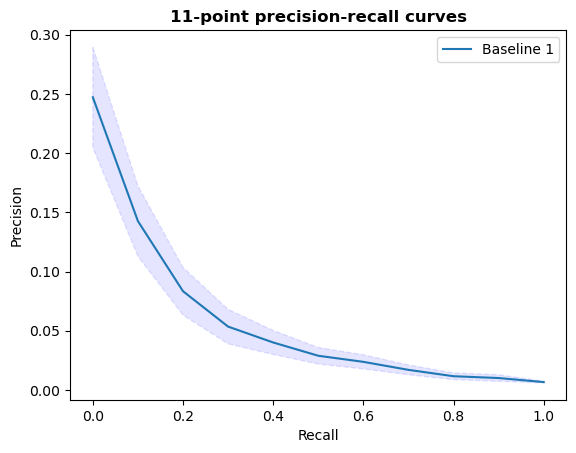

In [8]:
std_recall = np.array(df_metrics['11-point-recall'].values.tolist()).std(axis=0)
se_recall = std_recall/np.sqrt(len(train))

std_precision = np.array(df_metrics['11-point-precision'].values.tolist()).std(axis=0)
se_precision = std_precision/np.sqrt(len(train))
                            
plt.plot(df_metrics.loc['average']['11-point-recall'],
         df_metrics.loc['average']['11-point-precision'])

plt.fill_between(df_metrics.loc['average']['11-point-recall'],
                 df_metrics.loc['average']['11-point-precision'] - se_precision,
                 df_metrics.loc['average']['11-point-precision'] + se_precision,
                 alpha = 0.1, color='b', linestyle = 'dashed', label='_se_')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('11-point precision-recall curves', fontweight='bold')
plt.legend(['Baseline 1'])

In [5]:
lmjm_model = LMJM(trials, arg_lambda = 0.32, lowercase = True, lemmatize = True, bigrams = False, stopwords='english')

In [6]:
df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])

for query in train:
    search_results = lmjm_model.get_top_query_results(query.query_content)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]

print(df_metrics.loc['average'])

P@10                                                           0.061702
recall                                                         0.219115
AP                                                              0.04912
NDCG5                                                          0.065319
MRR                                                            0.005035
11-point-precision    [0.17660530273921254, 0.14264043011914732, 0.1...
11-point-recall       [0.0, 0.09999999999999999, 0.19999999999999998...
Name: average, dtype: object


C:\Users\user\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
C:\Users\user\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
C:\Users\user\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shap

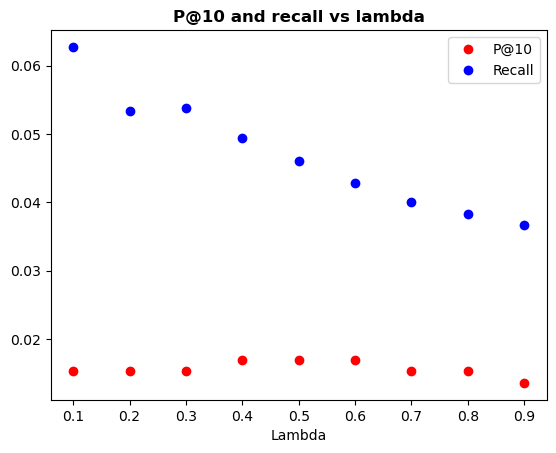

In [17]:
P10 = []
Recall = []
for l in np.arange(0.1, 1, 0.1):
    df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
    lmjm_model = LMJM(trials, arg_lambda = l, lowercase = False, lemmatize = False)
    
    for query in train:
        search_results = lmjm_model.get_top_query_results(query.query_content)
        eval = Evaluate(query, search_results)
        
        df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]
        
    df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]
    P10.append(df_metrics.loc['average']['P@10'])
    Recall.append(df_metrics.loc['average']['recall'])
                  
plt.plot(np.arange(0.1, 1, 0.1), P10, 'ro')
plt.plot(np.arange(0.1, 1, 0.1), Recall, 'bo')
plt.xlabel('Lambda')
plt.title('P@10 and recall vs lambda', fontweight='bold')
plt.legend(['P@10', 'Recall'])

In [ ]:
P10 = []
Recall = []
for l in np.arange(0.3, 0.41, 0.02):
    df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
    lmjm_model = LMJM(trials, arg_lambda = l, lowercase = False, lemmatize = False)
    
    for query in train:
        search_results = lmjm_model.get_top_query_results(query.query_content)
        eval = Evaluate(query, search_results)
        
        df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]
        
    df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]
    P10.append(df_metrics.loc['average']['P@10'])
    Recall.append(df_metrics.loc['average']['recall'])
                  
plt.plot(np.arange(0.3, 0.41, 0.02), P10, 'ro')
plt.plot(np.arange(0.3, 0.41, 0.02), Recall, 'bo')
plt.xlabel('Lambda')
plt.title('P@10 and recall vs lambda', fontweight='bold')
plt.legend(['P@10', 'Recall'])

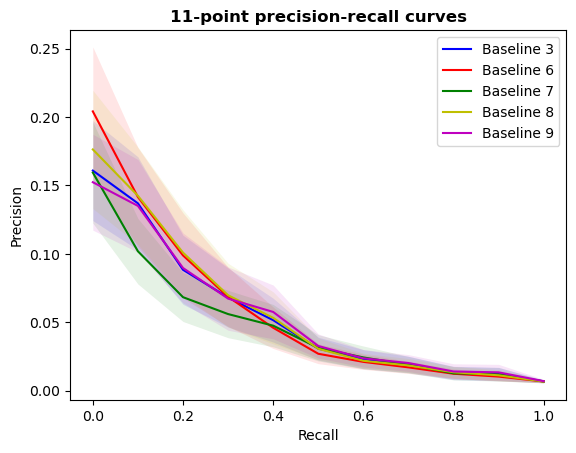

In [13]:
baselines = [{'lemmatization': False, 'bigrams': False, 'stopwords': None},
             {'lemmatization': True, 'bigrams': False, 'stopwords': None},
             {'lemmatization': False, 'bigrams': True, 'stopwords': None},
             {'lemmatization': True, 'bigrams': False, 'stopwords': 'english'},
             {'lemmatization': False, 'bigrams': False, 'stopwords': 'english'}]

baseline_metrics = pd.DataFrame(data=None, columns = ['11-point-precision', '11-point-recall',
                                                     'se-precision', 'se-recall'])

for idx, baseline in enumerate(baselines):
    lmjm_model = LMJM(trials, lowercase = True, arg_lambda = 0.32, 
                                    bigrams = baseline['bigrams'],
                                    lemmatize = baseline['lemmatization'],
                                    stopwords = baseline['stopwords'])
    
    df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
    
    for query in train:
        search_results = lmjm_model.get_top_query_results(query.query_content)
        eval = Evaluate(query, search_results)
    
        df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                          eval.mrr, eval.precision_11point, eval.recall_11point]

    df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                                 df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                                 df_metrics['MRR'].mean(), 
                                 np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                                 np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]
    
    std_recall = np.array(df_metrics['11-point-recall'].values.tolist()).std(axis=0)
    se_recall = std_recall/np.sqrt(len(train))

    std_precision = np.array(df_metrics['11-point-precision'].values.tolist()).std(axis=0)
    se_precision = std_precision/np.sqrt(len(train))
    
    baseline_metrics.loc[idx] = [df_metrics.loc['average']['11-point-precision'],
                                   df_metrics.loc['average']['11-point-recall'],
                                   se_precision, se_recall]
colors = ['b', 'r', 'g', 'y', 'm']
    
for i in range(0, 5):   
    plt.plot(baseline_metrics.loc[i]['11-point-recall'],
             baseline_metrics.loc[i]['11-point-precision'], color = colors[i])

    plt.fill_between(baseline_metrics.loc[i]['11-point-recall'],
                     baseline_metrics.loc[i]['11-point-precision'] - baseline_metrics.iloc[i]['se-precision'],
                     baseline_metrics.loc[i]['11-point-precision'] + baseline_metrics.iloc[i]['se-precision'],
                     alpha = 0.1, color=colors[i], linewidth = 0, label='_nolegend_')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('11-point precision-recall curves', fontweight='bold')
plt.legend(['Baseline 3', 'Baseline 6', 'Baseline 7', 'Baseline 8', 'Baseline 9'])

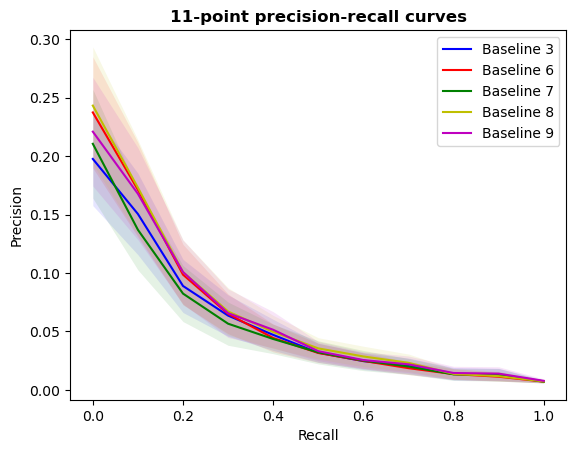

In [14]:
baselines = [{'lemmatization': False, 'bigrams': False, 'stopwords': None},
             {'lemmatization': True, 'bigrams': False, 'stopwords': None},
             {'lemmatization': False, 'bigrams': True, 'stopwords': None},
             {'lemmatization': True, 'bigrams': False, 'stopwords': 'english'},
             {'lemmatization': False, 'bigrams': False, 'stopwords': 'english'}]

baseline_metrics = pd.DataFrame(data=None, columns = ['11-point-precision', '11-point-recall',
                                                     'se-precision', 'se-recall'])

for idx, baseline in enumerate(baselines):
    vsm_model = VectorSpaceModel(trials, lowercase = True, 
                                    bigrams = baseline['bigrams'],
                                    lemmatize = baseline['lemmatization'],
                                    stopwords = baseline['stopwords'])
    
    df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
    
    for query in train:
        search_results = vsm_model.get_top_query_results(query.query_content)
        eval = Evaluate(query, search_results)
    
        df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                          eval.mrr, eval.precision_11point, eval.recall_11point]

    df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                                 df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                                 df_metrics['MRR'].mean(), 
                                 np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                                 np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]
    
    std_recall = np.array(df_metrics['11-point-recall'].values.tolist()).std(axis=0)
    se_recall = std_recall/np.sqrt(len(train))

    std_precision = np.array(df_metrics['11-point-precision'].values.tolist()).std(axis=0)
    se_precision = std_precision/np.sqrt(len(train))
    
    baseline_metrics.loc[idx] = [df_metrics.loc['average']['11-point-precision'],
                                   df_metrics.loc['average']['11-point-recall'],
                                   se_precision, se_recall]
colors = ['b', 'r', 'g', 'y', 'm']
    
for i in range(0, 5):   
    plt.plot(baseline_metrics.loc[i]['11-point-recall'],
             baseline_metrics.loc[i]['11-point-precision'], color = colors[i])

    plt.fill_between(baseline_metrics.loc[i]['11-point-recall'],
                     baseline_metrics.loc[i]['11-point-precision'] - baseline_metrics.iloc[i]['se-precision'],
                     baseline_metrics.loc[i]['11-point-precision'] + baseline_metrics.iloc[i]['se-precision'],
                     alpha = 0.1, color=colors[i], linewidth = 0, label='_nolegend_')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('11-point precision-recall curves', fontweight='bold')
plt.legend(['Baseline 3', 'Baseline 6', 'Baseline 7', 'Baseline 8', 'Baseline 9'])

P@10                                                               0.05
recall                                                         0.113915
AP                                                             0.037871
NDCG5                                                          0.068699
MRR                                                              0.0057
11-point-precision    [0.31644881681176157, 0.13226707887498215, 0.0...
11-point-recall       [0.0, 0.09999999999999999, 0.19999999999999998...
Name: average, dtype: object
P@10                                                           0.058333
recall                                                           0.1283
AP                                                             0.040118
NDCG5                                                          0.077172
MRR                                                              0.0057
11-point-precision    [0.33271710175225044, 0.1407018399511872, 0.08...
11-point-recall       [0.0, 0.09999

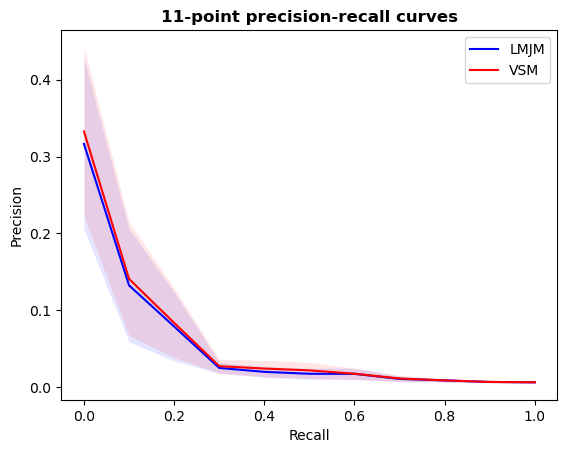

In [8]:
lmjm_model = LMJM(trials, lowercase = True, arg_lambda = 0.32, lemmatize = True, stopwords='english')
vector_model = VectorSpaceModel(trials, lowercase = True, lemmatize = True, stopwords='english')

test_metrics = pd.DataFrame(data=None, columns = ['11-point-precision', '11-point-recall',
                                                     'se-precision', 'se-recall'])
    
for idx, model in enumerate([lmjm_model, vector_model]):
    df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
    for query in test:
        search_results = model.get_top_query_results(query.query_content)
        eval = Evaluate(query, search_results)
    
        df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                          eval.mrr, eval.precision_11point, eval.recall_11point]

    df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                                 df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                                 df_metrics['MRR'].mean(), 
                                 np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                                 np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]
    print(df_metrics.loc['average'])
    
    std_recall = np.array(df_metrics['11-point-recall'].values.tolist()).std(axis=0)
    se_recall = std_recall/np.sqrt(len(test))

    std_precision = np.array(df_metrics['11-point-precision'].values.tolist()).std(axis=0)
    se_precision = std_precision/np.sqrt(len(test))
    
    test_metrics.loc[idx] = [df_metrics.loc['average']['11-point-precision'],
                                   df_metrics.loc['average']['11-point-recall'],
                                   se_precision, se_recall]
colors = ['b', 'r']
    
for i in range(0, 2):   
    plt.plot(test_metrics.loc[i]['11-point-recall'],
             test_metrics.loc[i]['11-point-precision'], color = colors[i])

    plt.fill_between(test_metrics.loc[i]['11-point-recall'],
                     test_metrics.loc[i]['11-point-precision'] - test_metrics.iloc[i]['se-precision'],
                     test_metrics.loc[i]['11-point-precision'] + test_metrics.iloc[i]['se-precision'],
                     alpha = 0.1, color=colors[i], linewidth = 0, label='_nolegend_')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('11-point precision-recall curves', fontweight='bold')
plt.legend(['LMJM', 'VSM'])